In [2]:
!pip install yfinance
!pip install fbprophet

     |████████████████████████████████| 6.3 MB 4.9 MB/s 
  Created wheel for yfinance: filename=yfinance-0.1.63-py2.py3-none-any.whl size=23918 sha256=35cf56db6305daaa447228e91e6f88f2f3beb8ea98e737d237e6d00d4205d2f7
  Stored in directory: /root/.cache/pip/wheels/fe/87/8b/7ec24486e001d3926537f5f7801f57a74d181be25b11157983
Successfully built yfinance
  Attempting uninstall: lxml
    Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6


In [3]:
from statsmodels.tsa.seasonal import seasonal_decompose
import pandas as pd
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller, kpss
import matplotlib.pyplot as plt
import yfinance as yf

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [4]:
df = yf.download('005930.KS', start='2016-01-01', end='2021-08-31')
df.tail()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2021-08-25,76200.0,76600.0,74900.0,75700.0,75700.0,22319664
2021-08-26,76100.0,76200.0,74600.0,74600.0,74600.0,16671494
2021-08-27,74300.0,75000.0,73800.0,74300.0,74300.0,15172748
2021-08-30,75400.0,75500.0,74200.0,74600.0,74600.0,12686999
2021-08-31,74900.0,76700.0,74300.0,76700.0,76700.0,24630370


# 데이터 기초분석

In [5]:
df.describe()    # 삼성 주가 

,Open,High,Low,Close,Adj Close,Volume
count,1384.000000,1384.000000,1384.000000,1384.000000,1384.000000,1.384000e+03
mean,49500.585260,49998.945087,49020.223988,49504.855491,46008.932914,1.463016e+07
std,15467.569951,15604.234335,15329.013050,15438.383127,16483.025364,8.280080e+06
min,21760.000000,22660.000000,21760.000000,22520.000000,19408.968750,0.000000e+00
25%,41770.000000,42100.000000,41487.500000,41840.000000,37275.034180,9.350674e+06
50%,47270.000000,47610.000000,46760.000000,47250.000000,43033.273438,1.247097e+07
75%,54855.000000,55500.000000,54300.000000,54925.000000,51502.114258,1.711926e+07
max,90300.000000,96800.000000,89500.000000,91000.000000,90198.078125,9.030618e+07


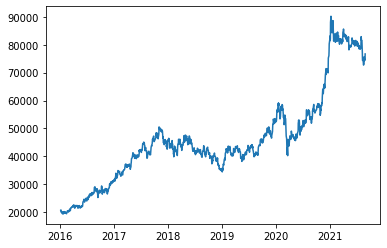

In [6]:
x = df['Adj Close']
y = df.index
plt.plot(y, x)

# fbprophet에 맞춘 데이터 분리
# adf, kpss 테스트

In [7]:
df_samsung = df.reset_index(drop=False, inplace=False)
df_samsung = df_samsung.rename(columns={'Date':'ds','Adj Close':'y'},inplace=False)
df_samsung = df_samsung.drop(['Open','High','Low','Close','Volume'], axis =1)

In [8]:
df_samsung.tail()

,ds,y
1379,2021-08-25,75700.0
1380,2021-08-26,74600.0
1381,2021-08-27,74300.0
1382,2021-08-30,74600.0
1383,2021-08-31,76700.0


In [12]:
adf_test(df_samsung.y)

Test Statistic              -0.765326
p-value                      0.829096
# of Lags Used              18.000000
# of Observations Used    1365.000000
Critical Value (1%)         -3.435150
Critical Value (5%)         -2.863660
Critical Value (10%)        -2.567899
dtype: float64

In [13]:
kpss_test(df_samsung.y)

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:1685: FutureWarning: The behavior of using lags=None will change in the next release. Currently lags=None is the same as lags='legacy', and so a sample-size lag length is used. After the next release, the default will change to be the same as lags='auto' which uses an automatic lag length selection method. To silence this warning, either use 'auto' or 'legacy'
  warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:1709: InterpolationWarning: p-value is smaller than the indicated p-value
  warn("p-value is smaller than the indicated p-value", InterpolationWarning)


Test Statistic            4.190858
p-value                   0.010000
# of Lags                24.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64

# 데이터 셋 나누기

In [14]:
df_samsung_train = df_samsung[df_samsung['ds']<='2021-07-31']
df_samsung_test = df_samsung[df_samsung['ds']>'2021-07-31']

In [ ]:
# train_indices = df_samsung.ds.apply(lambda x: x.year) <2020
# df_samsung_train = df_samsung.loc[train_indices].dropna()
# df_samsung_test = df_samsung.loc[~train_indices].reset_index(drop=True)

In [15]:
df_samsung_train

,ds,y
0,2016-01-04,20770.701172
1,2016-01-05,20822.406250
2,2016-01-06,20253.585938
3,2016-01-07,20046.742188
4,2016-01-08,20184.638672
...,...,...
1358,2021-07-26,78800.000000
1359,2021-07-27,78500.000000
1360,2021-07-28,79200.000000
1361,2021-07-29,79000.000000


In [16]:
test_y = df_samsung_test.y.values

# 모델링

In [17]:
from fbprophet import Prophet
from fbprophet import plot
from fbprophet.plot import add_changepoints_to_plot


In [35]:
model = Prophet(seasonality_mode='multiplicative')
model.fit(df_samsung_train)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


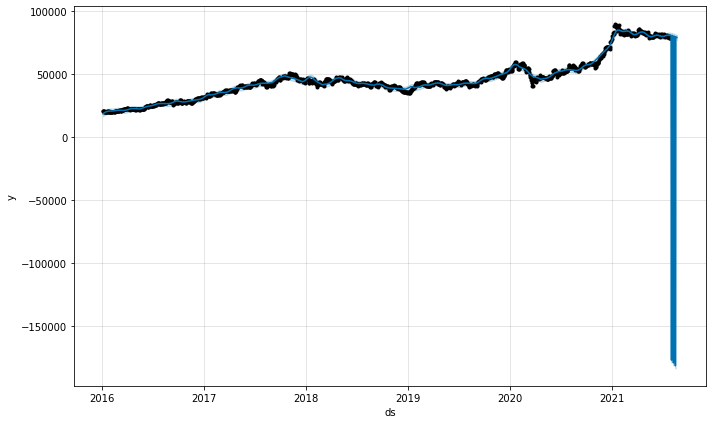

In [37]:
df_future1 = model.make_future_dataframe(periods=21, freq='d')
df_forecast1 = model.predict(df_future1)
model.plot(df_forecast1)
plt.tight_layout()
plt.show()

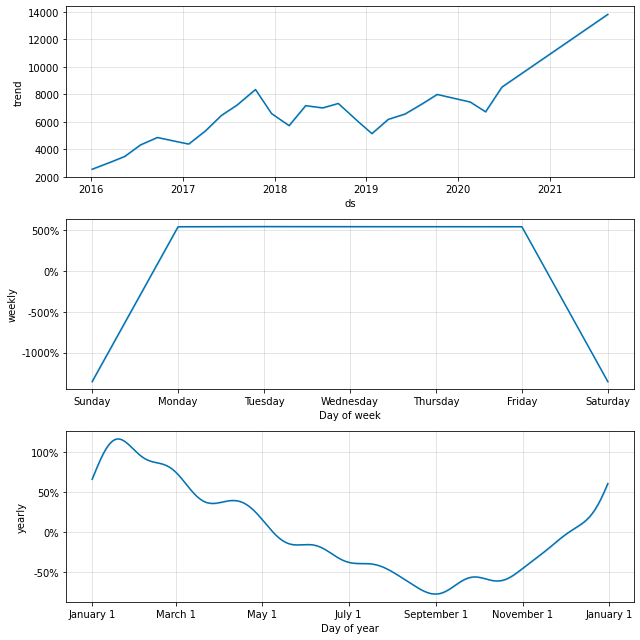

In [38]:
model.plot_components(df_forecast1)
plt.tight_layout()
plt.show()

In [39]:
df_forecast1[['ds','yhat', 'yhat_lower', 'yhat_upper']].tail(5)

,ds,yhat,yhat_lower,yhat_upper
1379,2021-08-16,79059.539262,77123.780555,81019.279942
1380,2021-08-17,79264.391831,77084.659182,81241.488051
1381,2021-08-18,79046.977998,76912.561818,81086.577728
1382,2021-08-19,78922.649579,76787.190349,81134.840328
1383,2021-08-20,78813.096391,76559.988309,80950.167689


# weekely seasonality False 로

In [41]:
prophet = Prophet(seasonality_mode = 'multiplicative',
                 yearly_seasonality=True, 
                 weekly_seasonality=False,
                 daily_seasonality=False,
                 changepoint_prior_scale=0.5)
prophet.fit(df_samsung_train)

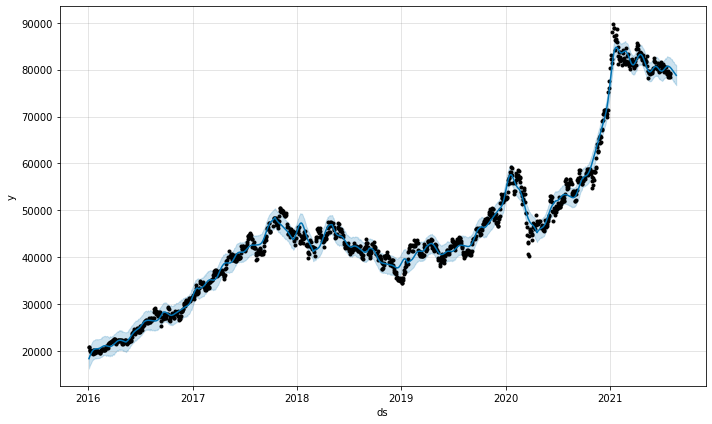

In [42]:
df_future = prophet.make_future_dataframe(periods=21, freq='d')
df_forecast = prophet.predict(df_future)
model.plot(df_forecast)
plt.tight_layout()
plt.show()

In [43]:
df_forecast[['ds','yhat', 'yhat_lower', 'yhat_upper']].tail(5)

,ds,yhat,yhat_lower,yhat_upper
1379,2021-08-16,79090.631507,77101.420672,81147.355633
1380,2021-08-17,79008.748812,76974.109827,81116.551975
1381,2021-08-18,78929.807718,76910.166191,81117.914013
1382,2021-08-19,78854.615024,76783.933012,80920.804555
1383,2021-08-20,78784.075931,76666.695741,80942.402446


In [44]:
pred_fbprophet_y = df_forecast.yhat.values[-21:]

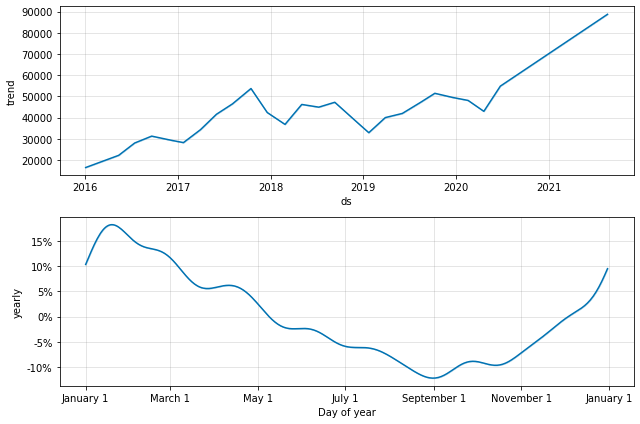

In [45]:
prophet.plot_components(df_forecast)
plt.tight_layout()
plt.show()

# change point!

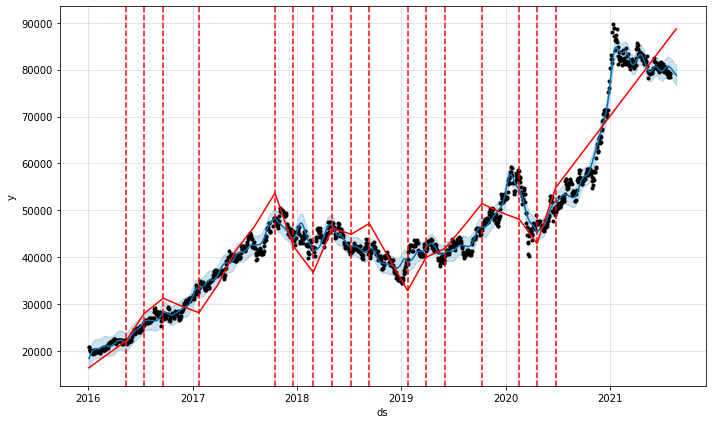

In [66]:
fig = prophet.plot(df_forecast)
add_changepoints_to_plot(fig.gca(), prophet, df_forecast, threshold=0.9)
plt.show()


# test 평가

Text(0.5, 1.0, 'comparison values')

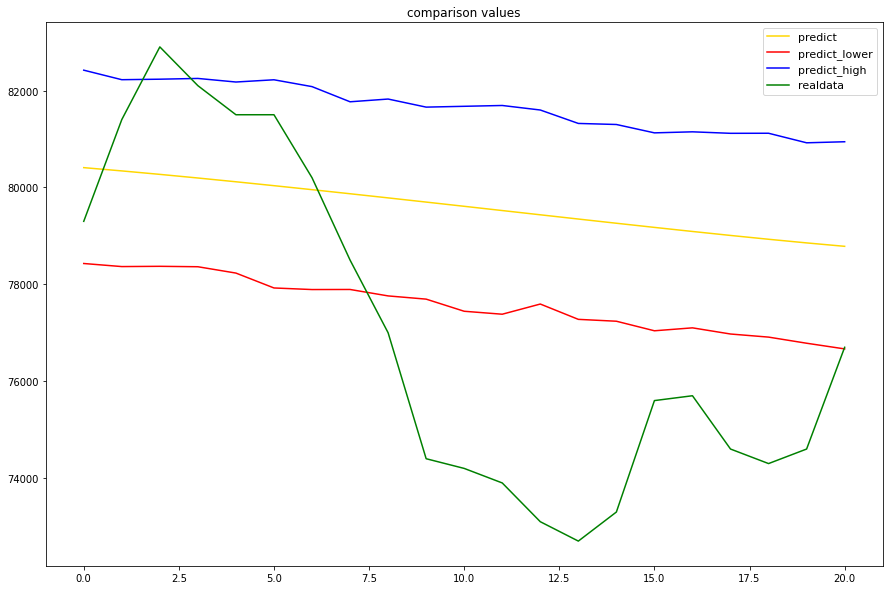

In [47]:
plt.figure(figsize=(15, 10))


# 실제 5일의 데이터 (2021-08-01 ~ 2021-08-31)
test_y = df_samsung.y.values[-21:]

# 마지막 30일의 예측 데이터 (2021-08-01 ~ 2021-08-31)
pred_fbprophet_y = df_forecast.yhat.values[-21:]

# 마지막 30일의 예측 데이터 최소값
pred_y_lower = df_forecast.yhat_lower.values[-21:]
# 마지막 30일의 예측 데이터 최대값
pred_y_upper = df_forecast.yhat_upper.values[-21:]

# 모델이 예측한 가격 그래프
plt.plot(pred_fbprophet_y, color = 'gold')

# 모델이 예측한 최저 가격 그래프
plt.plot(pred_y_lower, color = 'red')

# 모델이 예측한 최고 가격 그래프
plt.plot(pred_y_upper, color = 'blue')

# 실제 가격 그래프
plt.plot(test_y, color = 'green')

plt.legend(['predict', 'predict_lower','predict_high','realdata'])
plt.title("comparison values")

# 더 나은 결과를 위해.... ㅠㅠ

In [48]:
# 상한가 설정
df_samsung_train['cap'] = 90000

#하안가 설정
df_samsung_train['floor'] = 10000

# 상한가 적용을 위한 파라미터를 다음과 같이 설정
re_prophet = Prophet(seasonality_mode = 'multiplicative',
                 growth = 'logistic',
                 yearly_seasonality = True,
                 weekly_seasonality = False, 
                 daily_seasonality = False,
                 changepoint_prior_scale = 0.5)

re_prophet.fit(df_samsung_train)


# 414 예측 
df_future2 = re_prophet.make_future_dataframe(periods = 21, freq = 'd')


# 상한가 하한가 설정

df_future2['cap'] = 90000
df_future2['floor'] = 10000

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



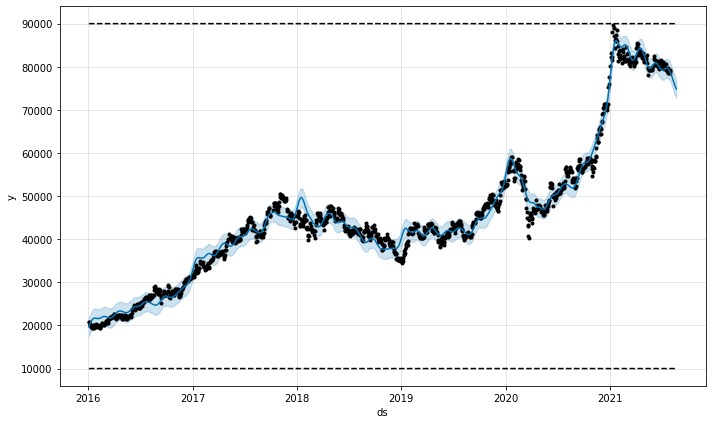

In [49]:
# 모델링
df_forecast2 = re_prophet.predict(df_future2)
re_prophet.plot(df_forecast2)
plt.tight_layout()
plt.show()

# 상한선 하한선 데이터 제거

In [50]:
df_del_samsung = df_samsung_train
df_del_samsung.loc[df_samsung_train['y'] > 90000, 'y'] = None
df_del_samsung.loc[df_samsung_train['y'] < 10000, 'y'] = None

# prophet 모델 학습
rere_prophet = Prophet(seasonality_mode = 'multiplicative',
                       growth = 'logistic',
                 yearly_seasonality = True,
                 weekly_seasonality = False,
                 daily_seasonality = False,
                 changepoint_prior_scale = 0.5)

rere_prophet.fit(df_del_samsung)

# 414일 예측 
df_future3 = rere_prophet.make_future_dataframe(periods = 21, freq = 'd')

# 상한가 하한가 설정
df_future3['cap'] = 90000
df_future3['floor'] = 10000

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



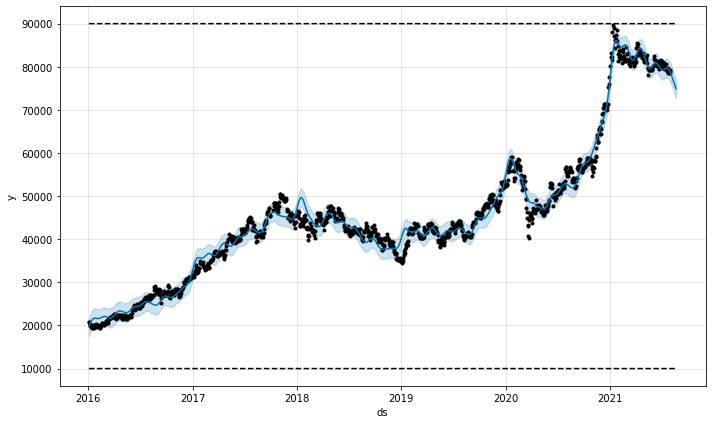

In [51]:
df_forecast3 = rere_prophet.predict(df_future3)
rere_prophet.plot(df_forecast3)
plt.tight_layout()
plt.show()

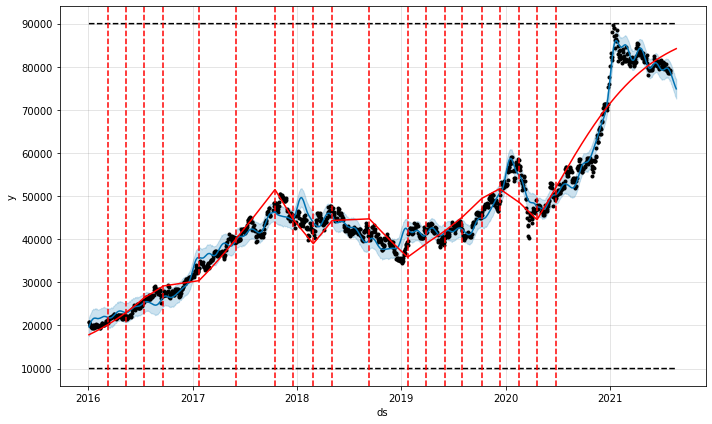

In [52]:
fig = rere_prophet.plot(df_forecast3)
add_changepoints_to_plot(fig.gca(), rere_prophet, df_forecast3)
plt.show()

In [53]:
df_forecast3[['ds','yhat', 'yhat_lower', 'yhat_upper']].tail(5)

,ds,yhat,yhat_lower,yhat_upper
1379,2021-08-16,75525.958015,73185.618948,77494.270476
1380,2021-08-17,75350.012784,73051.475822,77520.903777
1381,2021-08-18,75182.379422,72950.499250,77347.918575
1382,2021-08-19,75024.159061,72772.083310,77136.898132
1383,2021-08-20,74876.470098,72605.076142,77129.830335


In [54]:
pred_fbprophet_y_1 = df_forecast3.yhat.values[-21:]

# 모델 검정

In [55]:
len(test_y)

21

In [56]:
df_test = pd.DataFrame({'FBprophet predict':  pred_fbprophet_y,
                          'FBprophet predict remove outlier':pred_fbprophet_y_1,
                          'real data':test_y})

In [57]:
df_test

,FBprophet predict,FBprophet predict remove outlier,real data
0,80408.100009,78624.281689,79300.0
1,80340.688957,78456.396825,81400.0
2,80269.212113,78280.159168,82900.0
3,80194.242587,78096.620774,82100.0
4,80116.308104,77906.850955,81500.0
5,80035.887248,77711.924531,81500.0
6,79953.409432,77512.912780,80200.0
7,79869.258501,77310.877158,78500.0
8,79783.779727,77106.865741,77000.0
9,79697.289830,76901.912204,74400.0


In [58]:
from sklearn.metrics import mean_squared_error, r2_score
from math import sqrt

plt.figure(figsize=(20, 15))

# fbprophet 모델의  rmse
rmse_fbprophet = sqrt(mean_squared_error(pred_fbprophet_y, test_y))

# 전처리 진행한 fbprophet 모델의  rmse
rmse_fbprophet_1 = sqrt(mean_squared_error(pred_fbprophet_y_1, test_y))

<Figure size 1440x1080 with 0 Axes>

Text(0.5, 1.0, 'price compare')

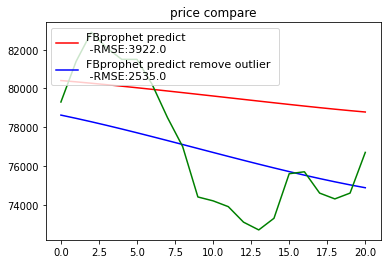

In [59]:
# fbprophet 예측 
plt.plot(df_test['FBprophet predict'], color = 'red')

# 오차 제거 예측
plt.plot(df_test[['FBprophet predict remove outlier']], color = 'blue')

# 실제 가격 그래프
plt.plot(test_y, color = 'green')

plt.rc('legend', fontsize=11)
plt.legend(['FBprophet predict \n -RMSE:' + str(round(rmse_fbprophet,0)),
            'FBprophet predict remove outlier \n -RMSE:' + str(round(rmse_fbprophet_1,0))], loc='upper left')
plt.title("price compare")

In [10]:
def adf_test(x):
    
    indices = ['Test Statistic', 'p-value',
               '# of Lags Used', '# of Observations Used']
    adf_test = adfuller(x, autolag='AIC')
    # if 'AIC' (default) or 'BIC', then the number of lags is chosen to minimize the corresponding information criterion
    # AIC가 디폴트 값인데, lag의 수준을 최적화하는 것으로 보면 됨.
    # H0은 non-stationary
    # H1은 stationary
    results = pd.Series(adf_test[0:4], index=indices)
    for key, value in adf_test[4].items():
        results[f'Critical Value ({key})'] = value

    return results

In [11]:
def kpss_test(x, h0_type='c'):

    indices = ['Test Statistic', 'p-value', '# of Lags']
    kpss_test = kpss(x, regression=h0_type)

    # regrssion = c or ct로 설정할 수 있음. 
    # c=contant : 해당 데이터가 정상성이 있다. 귀무가설에 해당함. (H0 = stationary)
    # ct=data is stationary around a trend lags : 해당 데이터에 트랜드를 제거하는 것이 정상성을 만드는 방법
    results = pd.Series(kpss_test[0:3], index=indices)
    for key, value in kpss_test[3].items():
        results[f'Critical Value ({key})'] = value

    return results

In [ ]:
from statsmodels.tsa.stattools import kpss
def kpss_test(timeseries):
    print ('Results of KPSS Test:')
    kpsstest = kpss(timeseries, regression='c', nlags="auto")
    kpss_output = pd.Series(kpsstest[0:3], index=['Test Statistic','p-value','Lags Used'])
    for key,value in kpsstest[3].items():
        kpss_output['Critical Value (%s)'%key] = value
    print (kpss_output)

In [ ]:
def kpss_test(df):
  statistic, p_value, n_lags, critical_values = kpss(df.y)

  print(f'KPSS Statistic: {statistic}')
  print(f'p-value: {p_value}')
  print(f'num lags: {n_lags}')
  print(f'Critial Values: {critical_values}')
  for key, value in critical_values.items():
    print(f' {key} : {value}')

AttributeError: ignored

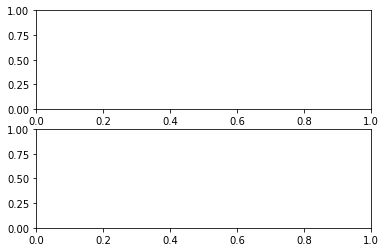

In [ ]:
N_LAGS = 40
SIGNIFICANCE_LEVEL = 0.05

#Lag는 40으로, 유의수준은 5% 지정하였음. 만약 이를 바꾸고 싶으면 정의한 부분을 변경하면 됨.

fig, ax = plt.subplots(2, 1)
plot_acf(df_samsung.y, ax=ax[0], lags=N_LAGS, alpha=SIGNIFICANCE_LEVEL)
plot_pacf(df_samsung.y, ax=ax[1], lags=N_LAGS, alpha=SIGNIFICANCE_LEVEL)
plt.tight_layout()